In [399]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [400]:
from enum import Enum

class Action(Enum):
    DEFECT = 0
    COOPERATE = 1

In [401]:
# returns the probabilities of the actions  
def boltzmann_exploration(q_table: np.array, state: Action, temperature: float) -> np.array:
    exp = np.exp((q_table[state.value, :] - np.max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

In [402]:
def prisoners_dilemma(a_i: Action, a_j: Action) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

In [403]:
def q_learning(qtable: np.array, max_qtable: np.array, state: Action, action: Action, 
               reward: float, new_state: Action, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(max_qtable[new_state.value, :]))

In [404]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 last_action: Action = None, qtable_ps: np.array = None, qtable_pd: np.array = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = Action(random.getrandbits(1)) if last_action == None else last_action
        self.qtable_ps = np.zeros((2, 2)) if qtable_ps == None else qtable_ps
        self.qtable_pd = np.zeros((2, 2)) if qtable_pd == None else qtable_pd

    def get_action_ps(self, state: Action) -> Action:
        temp = boltzmann_exploration(self.qtable_ps, state, self.t)
        return np.random.choice([Action.DEFECT, Action.COOPERATE], p=temp)
    
    def get_action_pd(self, state: Action) -> Action:
        temp = boltzmann_exploration(self.qtable_pd, state, self.t)
        return np.random.choice([Action.DEFECT, Action.COOPERATE], p=temp)
    
    def train(self, trajectories):
        for trajectory in trajectories:
            q_learning(self.qtable_pd, self.qtable_ps, trajectory[2], trajectory[3], trajectory[5], trajectory[4], self.a, self.g)
            q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], 0, trajectory[2], self.a, self.g)
            # print (trajectory)
            # print(self.qtable_ps)
            # print(self.qtable_pd)

In [405]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    recorded_outcomes = {
        (Action.DEFECT, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.DEFECT, Action.COOPERATE): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.COOPERATE): [0 for _ in range(episodes)],
    }

    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))

    
    for episode in range(episodes):

        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = agents[j].last_action
                s_j = agents[i].last_action
                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)

                if a_i == Action.DEFECT or a_j == Action.DEFECT:
                    unpaired.append(i)
                    unpaired.append(j)
                else:
                    temp_pairs.append((i, j))

                trajectories[i].append((s_i, a_i))
                trajectories[j].append((s_j, a_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                s_i = agents[j].last_action
                s_j = agents[i].last_action
                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                recorded_outcomes[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j

                t = trajectories[i][-1]
                trajectories[i][-1] = (t[0], t[1], s_i, a_i, a_j, r_i)
                t = trajectories[j][-1]
                trajectories[j][-1] = (t[0], t[1], s_j, a_j, a_i, r_j)

        pass
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
        pass

        
        

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.COOPERATE)], linewidth=1)
    
    plt.xlabel('Episode')
    plt.ylabel('Number of Outcomes')
    plt.ylim(0, population * rounds / 2)
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)"])

    plt.show()

    ps_strategies = [
        ("Always-Stay", np.array([[0, 1], [0, 1]])),
        ("Out-for-Tat", np.array([[1, 0], [0, 1]])),
        ("Reverse-OFT", np.array([[0, 1], [1, 0]])),
        ("Always-Switch", np.array([[1, 0], [1, 0]])),
    ]
    pd_strategies = [
        ("Always-Cooperate", np.array([[0, 1], [0, 1]])),
        ("Tit-for-Tat", np.array([[1, 0], [0, 1]])),
        ("Reverse-TFT", np.array([[0, 1], [1, 0]])),
        ("Always-Defect", np.array([[1, 0], [1, 0]])),
    ]
    
    num_strategies_ps = [0 for _ in ps_strategies]
    num_strategies_pd = [0 for _ in pd_strategies]

    # print("Episode %i" % (episode))
    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = 0
        strategy_ps_angle = 90
        for ps_idx, strategy in enumerate(ps_strategies):
            agent_norm = np.linalg.norm(agent.qtable_ps)
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable_ps * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_ps_angle:
                strategy_ps = ps_idx
                strategy_ps_angle = angle

        strategy_pd = 0
        strategy_pd_angle = 90
        for pd_idx, strategy in enumerate(pd_strategies):
            agent_norm = np.linalg.norm(agent.qtable_pd)
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable_pd * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_pd_angle:
                strategy_pd = pd_idx
                strategy_pd_angle = angle
        
        num_strategies_ps[strategy_ps] += 1
        num_strategies_pd[strategy_pd] += 1
        print("Agent %i) PS-Strategy: %s (%fdeg), PD-Strategy: %s (%fdeg)" % 
            (idx, ps_strategies[strategy_ps][0], strategy_ps_angle, pd_strategies[strategy_pd][0], strategy_pd_angle))
        print(agent.qtable_ps)
        print(agent.qtable_pd)

    plt.subplot(211)
    plt.bar([s[0] for s in ps_strategies], num_strategies_ps)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    plt.bar([s[0] for s in pd_strategies], num_strategies_pd)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()


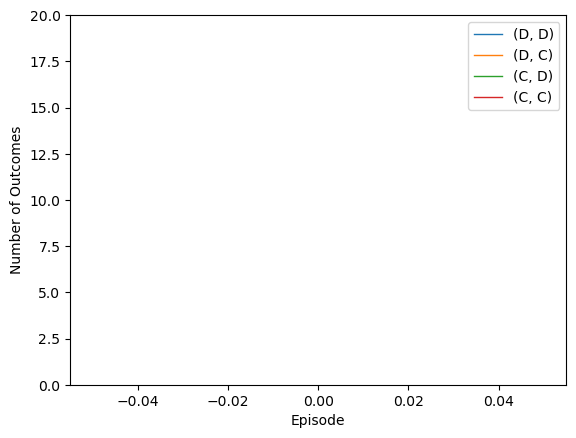

Agent 0) PS-Strategy: Always-Switch (32.533293deg), PD-Strategy: Always-Defect (16.763651deg)
[[0.15803228 0.0852048 ]
 [0.1802784  0.12561215]]
[[0.98053529 0.1504031 ]
 [0.95521198 0.383483  ]]
Agent 1) PS-Strategy: Out-for-Tat (30.422868deg), PD-Strategy: Tit-for-Tat (29.404974deg)
[[0.183217   0.07479686]
 [0.04047165 0.08317966]]
[[0.98518684 0.13307105]
 [0.30600631 0.37854287]]


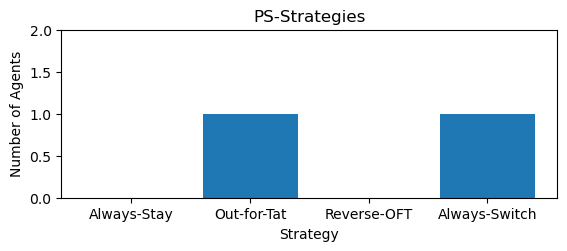

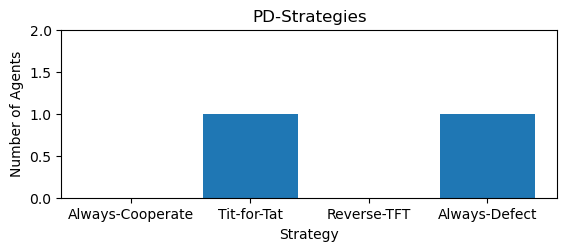

In [406]:
sdoo(2, 20, 1, 0.05, 1, 1)